In [204]:
# import statements
import pandas as pd
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import shap

# Data Loading and PreProcessing

In [205]:
basketball_data = pd.read_excel("BasketballData.xlsx")
basketball_data

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,1,Nikola Jokic,28,DEN,79.0,926.0,990,0.935,79,34.6,...,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299,2024
1,2,Shai Gilgeous-Alexander,25,OKC,15.0,640.0,990,0.646,75,34.0,...,5.5,6.2,2.0,0.9,0.535,0.353,0.874,14.6,0.275,2024
2,3,Luka Doncic,24,DAL,4.0,566.0,990,0.572,70,37.5,...,9.2,9.8,1.4,0.5,0.487,0.382,0.786,12.0,0.220,2024
3,4,Giannis Antetokounmpo,29,MIL,1.0,192.0,990,0.194,73,35.2,...,11.5,6.5,1.2,1.1,0.611,0.274,0.657,13.2,0.246,2024
4,5,Jalen Brunson,27,NYK,0.0,142.0,990,0.143,77,35.4,...,3.6,6.7,0.9,0.2,0.479,0.401,0.847,11.2,0.198,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,24T,Bobby Jones,29,PHI,0.0,3.0,690,0.004,81,25.3,...,5.4,2.8,1.2,0.9,0.539,0.000,0.813,9.2,0.217,1981
706,24T,Mike Mitchell,25,CLE,0.0,3.0,690,0.004,82,39.0,...,6.1,1.7,0.8,0.6,0.476,0.444,0.784,6.0,0.091,1981
707,24T,James Silas,31,SAS,0.0,3.0,690,0.004,75,27.4,...,3.1,3.8,0.7,0.2,0.477,0.000,0.850,7.0,0.164,1981
708,30T,Quinn Buckner,26,MIL,0.0,1.0,690,0.001,82,29.1,...,3.6,4.7,2.4,0.0,0.493,0.167,0.734,5.4,0.108,1981


As stated, our test set will be the 2023-2024 season, and the training set all the other seasons/observations. Additionally, there are some columns that aren't going to be needed in our analysis and will be removed

Rank: Directly relates to Win Shares, removed for obvious reasons

First: Also Directly Relates to Win Shares, removed for obvious reasons

Player: Will only be used to reference who wins MVP when seeing the results of our models, but not for the models themselves

Tm/Team: Irrelevant to Win Shares

Pts Won: Used with Pts Max to determine the Share percentage, redundant

Pts Max: Again, redundant, as we already have Share

Year: Only used to differentiate between the training and test set, but not for the models themselves

We also replace any Na's with the column averages

In [206]:
train_data = basketball_data[basketball_data["Year"] < 2024]
test_data = basketball_data[basketball_data["Year"] == 2024]

In [207]:
columns_to_remove = ['Rank', 'Player', 'Tm', 'First', 'Pts Won', 'Pts Max', 'Year']
train_data = train_data.drop(columns=columns_to_remove)
test_data = test_data.drop(columns=columns_to_remove)

train_data = train_data.fillna(train_data.mean())
test_data = test_data.fillna(test_data.mean())

In [208]:
X_train = train_data.drop(columns=['Share'])
y_train = train_data['Share']

X_test = test_data.drop(columns=['Share'])
y_test = test_data['Share']

We also have to normalize our data; this helps avoid feature bias and unoptimal results for Logistic Regression and SVM.

In [209]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_test

,Age,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48
0,28,79,34.6,26.4,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299
1,25,75,34.0,30.1,5.5,6.2,2.0,0.9,0.535,0.353,0.874,14.6,0.275
2,24,70,37.5,33.9,9.2,9.8,1.4,0.5,0.487,0.382,0.786,12.0,0.220
3,29,73,35.2,30.4,11.5,6.5,1.2,1.1,0.611,0.274,0.657,13.2,0.246
4,27,77,35.4,28.7,3.6,6.7,0.9,0.2,0.479,0.401,0.847,11.2,0.198
5,25,74,35.7,26.9,8.1,4.9,1.0,0.6,0.471,0.376,0.833,10.4,0.189
6,22,79,35.1,25.9,5.4,5.1,1.3,0.5,0.461,0.357,0.836,7.5,0.130
7,27,82,35.7,19.4,13.7,8.2,0.9,0.6,0.594,0.379,0.704,12.6,0.206
8,35,75,37.2,27.1,6.6,5.0,0.9,1.2,0.523,0.413,0.856,8.3,0.142


We are now ready to begin building our models

# Model Building

## Linear Regression

We don't really have any hyperparameters to tune for Linear Regression, so we can continue as is

In [210]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_scaled, y_train)

y_pred = lin_reg.predict(X_test_scaled)

In [211]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

C:\Users\Nav\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [212]:
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.1998
R²: 0.6154


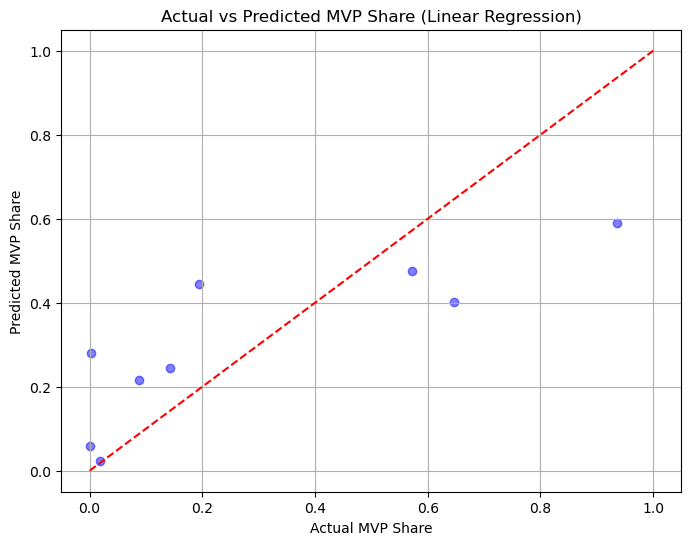

In [213]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predictions")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('Actual vs Predicted MVP Share (Linear Regression)')
plt.grid(True)
plt.show()

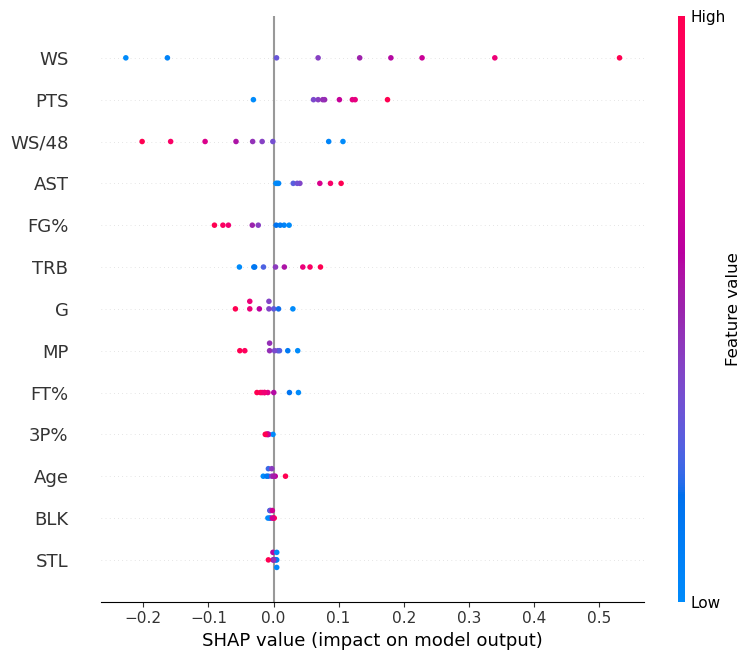

In [214]:
column_names = ['Age','G', 'MP', 'PTS', 'TRB', 'AST', 'STL', 'BLK', 'FG%',
       '3P%', 'FT%', 'WS', 'WS/48']

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=column_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=column_names)

explainer = shap.LinearExplainer(lin_reg, X_train_scaled_df)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values, X_test_scaled_df, show=False)
plt.savefig("lin.png")

In [215]:
mvp_predictions = pd.DataFrame({
    'Player': basketball_data.loc[basketball_data['Year'] == 2024, 'Player'],  
    'Predicted_MVP_Share': y_pred
})

mvp_predictions_sorted = mvp_predictions.sort_values(by='Predicted_MVP_Share', ascending=False)

predicted_mvp = mvp_predictions_sorted.iloc[0]
print(f"Predicted MVP: {predicted_mvp['Player']} with MVP Share: {predicted_mvp['Predicted_MVP_Share']:.4f}")

Predicted MVP: Nikola Jokic with MVP Share: 0.5887


## SVM

For SVM, we have three hyperparameters:

C: Controls the trade-off between achieving a low error on the training data and minimizing the complexity of the model (overfitting vs underfitting).

Kernel: Defines the type of hyperplane used to separate the data.

Gamma: Defines how far the influence of a single training example reaches

We use GridSearchCV to find the optimal ones

In [216]:
svm = SVR() # Using a support vector regressor, as we are doing regression, not classification

In [217]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3]
}

In [218]:
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.1, 0.2, 0.3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             scoring='neg_mean_squared_error')

In [219]:
best_params = grid_search.best_params_
svm_best = grid_search.best_estimator_

In [220]:
print("Best hyperparameters for SVM:")
print(grid_search.best_params_)

Best hyperparameters for SVM:
{'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}


In [221]:
y_pred = svm_best.predict(X_test_scaled)

In [222]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Best Hyperparameters:", best_params)
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Best Hyperparameters: {'C': 0.1, 'epsilon': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
RMSE: 0.1371
R²: 0.8188


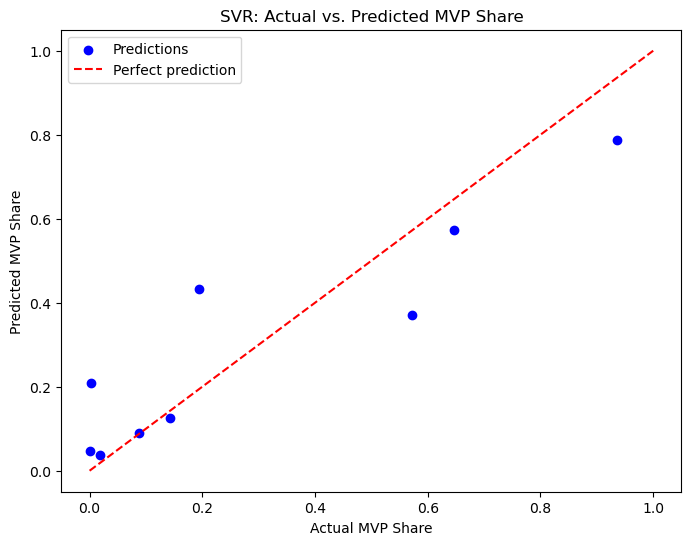

In [223]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label="Predictions")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Perfect prediction")
plt.xlabel("Actual MVP Share")
plt.ylabel("Predicted MVP Share")
plt.title("SVR: Actual vs. Predicted MVP Share")
plt.legend()
plt.show()

Using 701 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/9 [00:00<?, ?it/s]

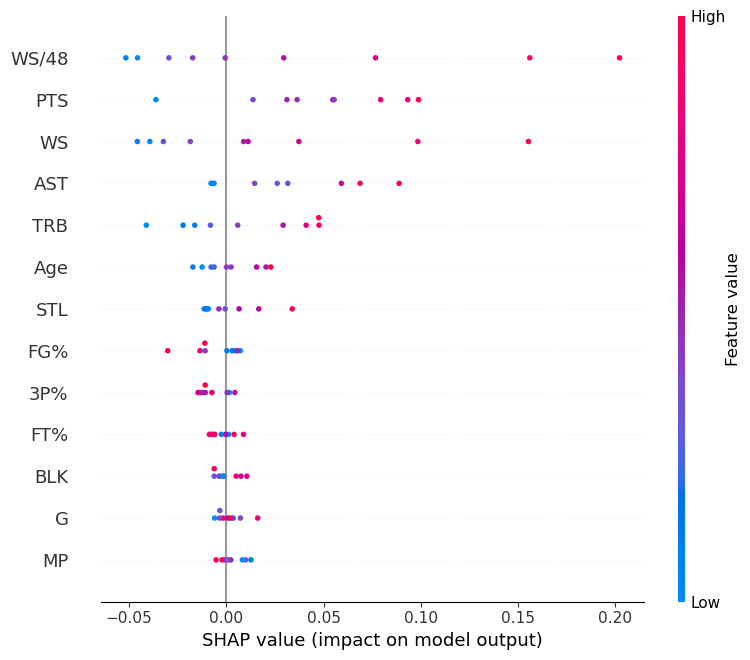

In [224]:
explainer = shap.KernelExplainer(svm_best.predict, X_train_scaled_df)
shap_values = explainer.shap_values(X_test_scaled_df)
shap.summary_plot(shap_values, X_test_scaled_df, show=False)
plt.savefig("svm.png")

In [225]:
mvp_predictions = pd.DataFrame({
    'Player': basketball_data.loc[basketball_data['Year'] == 2024, 'Player'],  
    'Predicted_MVP_Share': y_pred
})

mvp_predictions_sorted = mvp_predictions.sort_values(by='Predicted_MVP_Share', ascending=False)

predicted_mvp = mvp_predictions_sorted.iloc[0]
print(f"Predicted MVP: {predicted_mvp['Player']} with MVP Share: {predicted_mvp['Predicted_MVP_Share']:.4f}")

Predicted MVP: Nikola Jokic with MVP Share: 0.7872


## Random Forest

We have several hyperparameters for Random Forest

n_estimators: The number of trees in the forest

max_depth: The maximum depth of the trees

min_samples_split: The minimum number of samples required to split an internal node

min_samples_leaf: The minimum number of samples required to be at a leaf node

max_features: The number of features to consider when looking for the best split

We use GridSearchCV to find the optimal ones

In [226]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
    'bootstrap': [True, False]
}

In [227]:
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [228]:
best_params = grid_search.best_params_
print("Best hyperparameters for Random Forest:")
print(grid_search.best_params_)

Best hyperparameters for Random Forest:
{'bootstrap': True, 'max_depth': 10, 'max_features': 0.4, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


In [229]:
best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_scaled)

rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("Random Forest Model:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Random Forest Model:
RMSE: 0.1443
R²: 0.7995


C:\Users\Nav\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


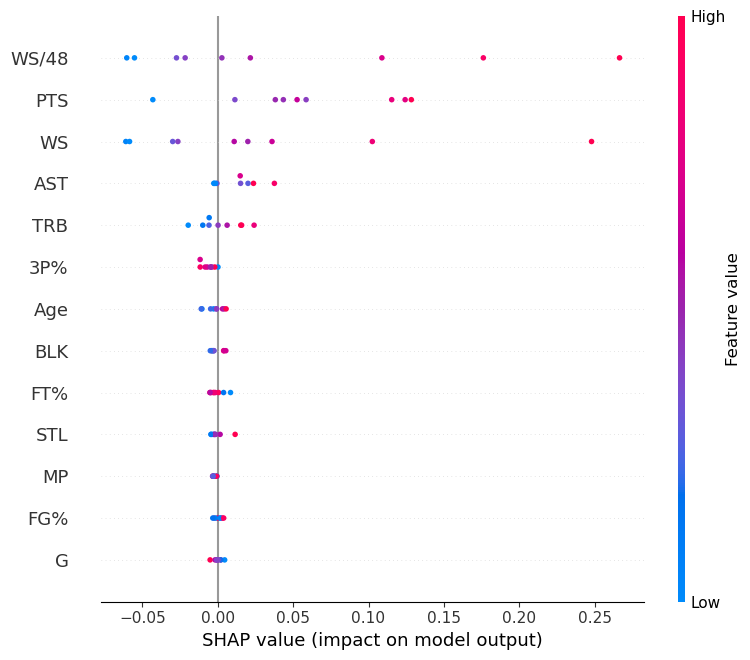

In [230]:
explainer = shap.TreeExplainer(best_rf, X_train_scaled_df)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)
plt.savefig("forest.png")

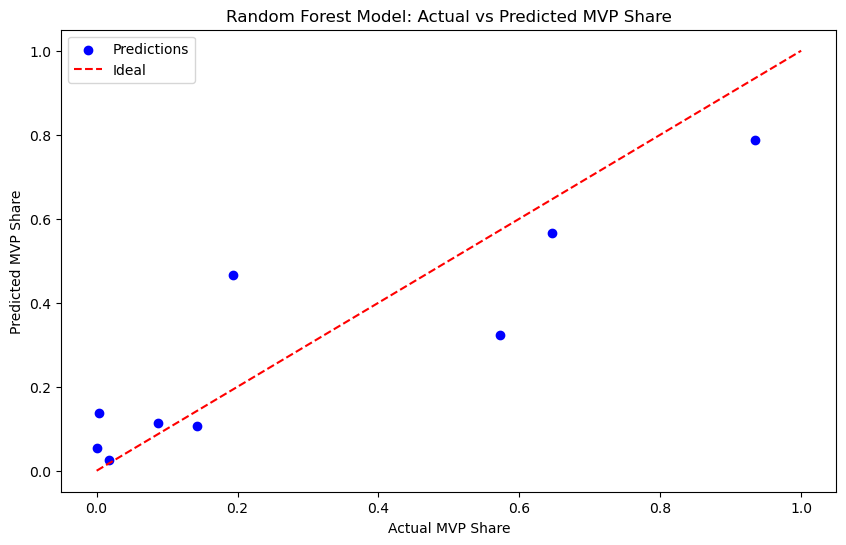

In [231]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('Random Forest Model: Actual vs Predicted MVP Share')
plt.legend()
plt.show()

In [232]:
mvp_predictions = pd.DataFrame({
    'Player': basketball_data.loc[basketball_data['Year'] == 2024, 'Player'],
    'Predicted_MVP_Share': y_pred
})

mvp_predictions_sorted = mvp_predictions.sort_values(by='Predicted_MVP_Share', ascending=False)

predicted_mvp = mvp_predictions_sorted.iloc[0]
print(f"Predicted MVP: {predicted_mvp['Player']} with MVP Share: {predicted_mvp['Predicted_MVP_Share']:.4f}")

Predicted MVP: Nikola Jokic with MVP Share: 0.7883


## XGBoost

We have several hyperparameters for Xgboost

n_estimators: Number of boosting rounds.

learning_rate: Step size shrinkage used in updates to prevent overfitting.

max_depth: Maximum depth of a tree.

subsample: Fraction of samples used for training each tree.

colsample_bytree: Fraction of features to consider when building each tree.

gamma: Minimum loss reduction required to make a split

We use GridSearchCV to find the optimal ones

In [233]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [234]:
xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\Nav\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0], 'gamma': [0, 1, 5],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             verbose=2)

In [235]:
best_params = grid_search.best_params_
print("Best hyperparameters for XGBoost:")
print(grid_search.best_params_)

Best hyperparameters for XGBoost:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [236]:
best_xgb = grid_search.best_estimator_

y_pred = best_xgb.predict(X_test_scaled)

In [237]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("XGBoost Model:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

XGBoost Model:
RMSE: 0.1269
R²: 0.8447


C:\Users\Nav\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


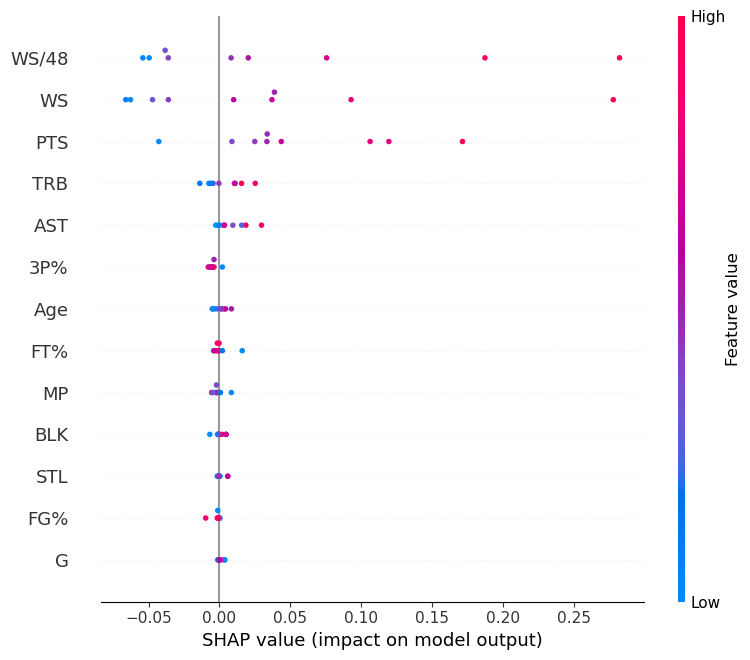

In [238]:
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)
plt.savefig("xg.png")

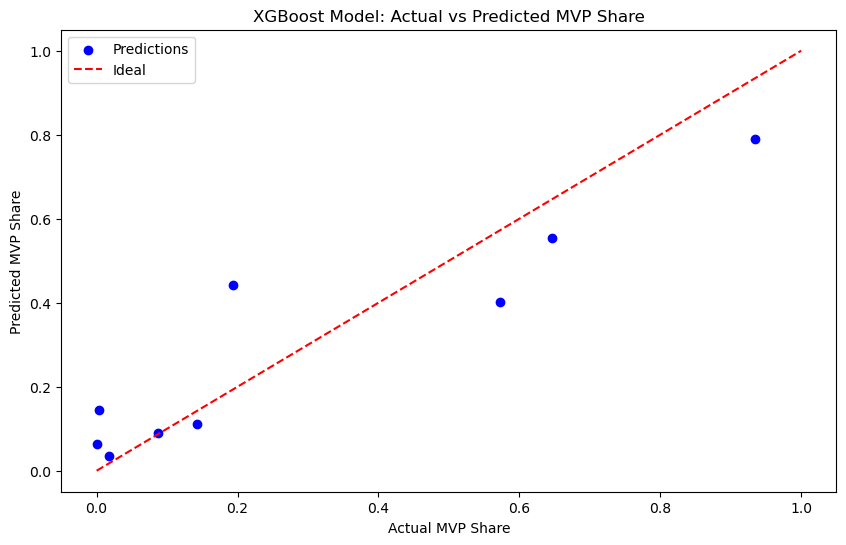

In [239]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal')
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('XGBoost Model: Actual vs Predicted MVP Share')
plt.legend()
plt.show()

In [240]:
mvp_predictions = pd.DataFrame({
    'Player': basketball_data.loc[basketball_data['Year'] == 2024, 'Player'],
    'Predicted_MVP_Share': y_pred
})

mvp_predictions_sorted = mvp_predictions.sort_values(by='Predicted_MVP_Share', ascending=False)

predicted_mvp = mvp_predictions_sorted.iloc[0]
print(f"Predicted MVP: {predicted_mvp['Player']} with MVP Share: {predicted_mvp['Predicted_MVP_Share']:.4f}")

Predicted MVP: Nikola Jokic with MVP Share: 0.7898


## AdaBoost

We have 3 hyperparameters for Adaboost

n_estimators: Number of weak learners (trees).

learning_rate: Shrinkage factor applied to weights of weak learners.

base_estimator: The weak learner to be boosted (usually DecisionTreeRegressor with restricted depth).

We use GridSearchCV to find the optimal ones

In [241]:
base_estimator = DecisionTreeRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'estimator__max_depth': [1, 3, 5]
}

In [242]:
ada = AdaBoostRegressor(estimator=base_estimator, random_state=42)

grid_search = GridSearchCV(estimator=ada, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(random_state=42),
                                         random_state=42),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 3, 5],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [243]:
best_params = grid_search.best_params_
print("Best hyperparameters for Adaboost:")
print(grid_search.best_params_)

Best hyperparameters for Adaboost:
{'estimator__max_depth': 3, 'learning_rate': 0.01, 'n_estimators': 200}


In [244]:
best_ada = grid_search.best_estimator_

y_pred = best_ada.predict(X_test_scaled)

In [245]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print("AdaBoost Model:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

AdaBoost Model:
RMSE: 0.1382
R²: 0.8159


C:\Users\Nav\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


PermutationExplainer explainer: 10it [00:10, 10.60s/it]              


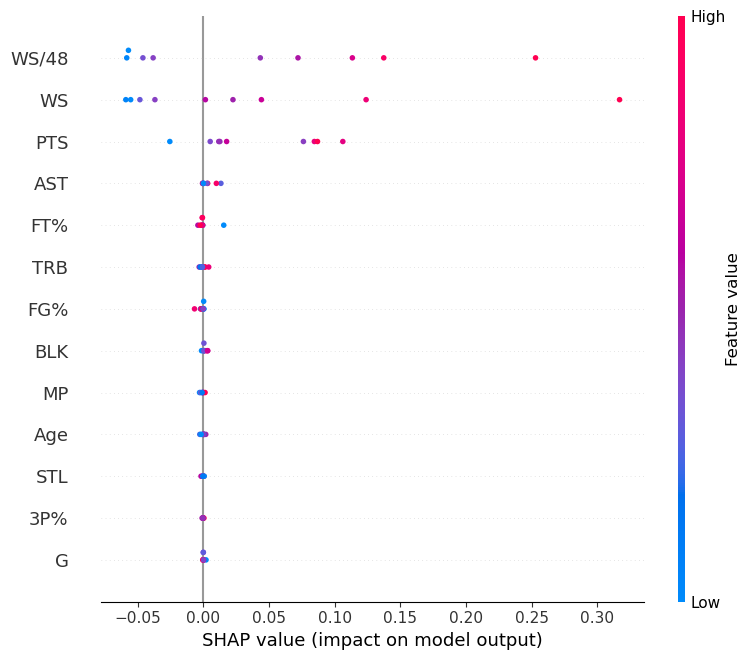

In [246]:
explainer = shap.Explainer(best_ada.predict, X_train_scaled)
shap_values = explainer(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, show=False)
plt.savefig("ada.png")

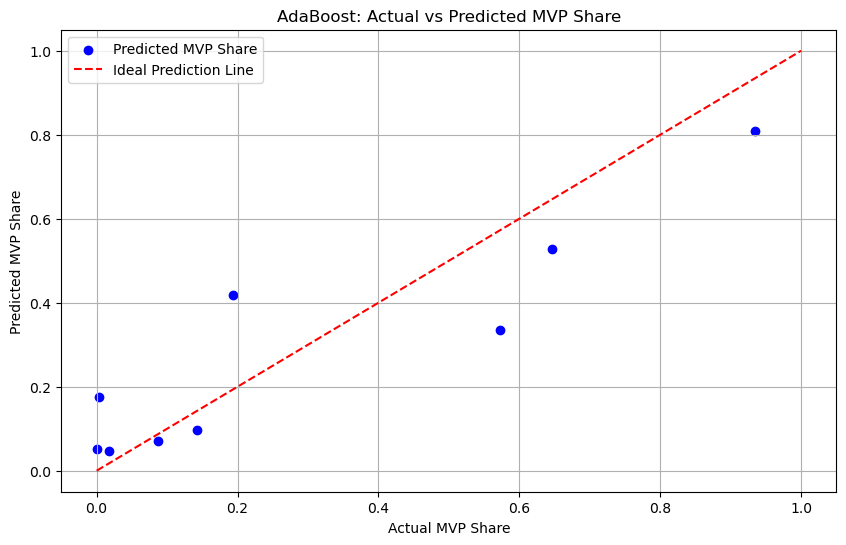

In [247]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted MVP Share')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Ideal Prediction Line')
plt.xlabel('Actual MVP Share')
plt.ylabel('Predicted MVP Share')
plt.title('AdaBoost: Actual vs Predicted MVP Share')
plt.legend()
plt.grid()
plt.show()

In [248]:
mvp_predictions = pd.DataFrame({
    'Player': basketball_data.loc[basketball_data['Year'] == 2024, 'Player'],
    'Predicted_MVP_Share': y_pred
})

mvp_predictions_sorted = mvp_predictions.sort_values(by='Predicted_MVP_Share', ascending=False)

predicted_mvp = mvp_predictions_sorted.iloc[0]
print(f"Predicted MVP: {predicted_mvp['Player']} with MVP Share: {predicted_mvp['Predicted_MVP_Share']:.4f}")

Predicted MVP: Nikola Jokic with MVP Share: 0.8083
